data/data.csv
有重複資料
562 => 522

In [2]:
import time
import pickle

import statistics

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data
import torch.nn.functional as F
import matplotlib
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import datasets
from sklearn import svm
from sklearn.metrics import f1_score

In [2]:
from Features.dle import dle

In [18]:
x = np.load("data/linear_features/score_history/score_history.npy")
print(x.shape)
print(x[x[:, 3].argsort()][::-1][:20])

(64, 4)
[[ 4.          6.          3.          0.93839836]
 [ 4.         10.          3.          0.92813142]
 [ 4.          4.          3.          0.92813142]
 [ 4.          4.          1.          0.92607803]
 [ 4.          8.          3.          0.92402464]
 [ 3.          4.          3.          0.90965092]
 [ 4.          8.          1.          0.89117043]
 [ 4.          6.          1.          0.88706366]
 [ 3.          6.          3.          0.88501027]
 [ 4.         10.          1.          0.88295688]
 [ 3.          8.          3.          0.88090349]
 [ 4.          6.          2.          0.87679671]
 [ 3.         10.          3.          0.86858316]
 [ 4.          4.          2.          0.85215606]
 [ 4.          8.          2.          0.85215606]
 [ 4.         10.          2.          0.85010267]
 [ 1.          8.          3.          0.81314168]
 [ 3.          4.          2.          0.79876797]
 [ 3.          6.          2.          0.79671458]
 [ 3.          6.      

In [3]:
df = pd.read_csv("data/society/cdhit80_data_seq.csv")
df.head(3)

,Unnamed: 0,Refseq_ID,Cytosolic,Nucleus,Gene_ID,Sequence
0,0,NR_002728.3,0.30,0.70,NCBI:10984,AGGCAGAACGGTCGCCGCGTCGCCTCAGCACGGACCTCCAGGGAGC...
1,1,NR_003255.2,0.25,0.75,NCBI:9383,TAAAAATGTAAAAGATCAGCTGGGTGTGGTGGCTCACACCTGTAAT...
2,2,NM_173600.2,0.20,0.80,NCBI:283463,AGACTTGTCTCTCCAGAATGACTATCCTCCATTTCTAGGTCCCAAA...


In [4]:
df = pd.read_csv("data/lncATLAS/2021-11-25_lncATLAS_all_data_RCI.csv")

In [5]:
cnrci = df[df["Data Type"] == "CNRCI"]
cnrci = cnrci[cnrci["Value"].notna()]
ensembl_id = cnrci["ENSEMBL ID"].unique()

In [7]:
cnrci

,ENSEMBL ID,Data Source,Data Type,Value,Gene Name,Coding Type,Biotype
0,ENSG00000000003,A549,CNRCI,1.080680,TSPAN6,coding,coding
2,ENSG00000000003,H1.hESC,CNRCI,1.857340,TSPAN6,coding,coding
3,ENSG00000000003,HeLa.S3,CNRCI,1.868390,TSPAN6,coding,coding
4,ENSG00000000003,HepG2,CNRCI,2.294360,TSPAN6,coding,coding
5,ENSG00000000003,HT1080,CNRCI,0.866395,TSPAN6,coding,coding
...,...,...,...,...,...,...,...
714484,ENSG00000283122,HepG2,CNRCI,-2.584960,HYMAI,nc,nc
714485,ENSG00000283122,HT1080,CNRCI,-1.485430,HYMAI,nc,nc
714487,ENSG00000283122,IMR.90,CNRCI,-3.305810,HYMAI,nc,nc
714494,ENSG00000283122,MCF.7,CNRCI,-3.544320,HYMAI,nc,nc


In [ ]:
variance = []
for eidx in ensembl_id:
    if len(cnrci[cnrci["ENSEMBL ID"] == eidx]["Value"]) > 1:
        variance.append(statistics.variance(cnrci[cnrci["ENSEMBL ID"] == eidx]["Value"]))

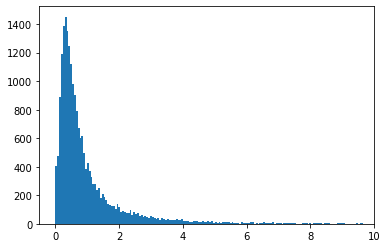

In [59]:
v_np = np.array(variance)
plt.hist(v_np, bins='auto')
plt.xlim(-0.5, 10)
plt.show()

In [74]:
nc_count = pd.DataFrame([], columns=["id", "N", "C"])
for eidx in ensembl_id:
    temp = pd.DataFrame([[eidx, len(cnrci[(cnrci["ENSEMBL ID"] == eidx) & (cnrci["Value"] > 0)]) , len(cnrci[(cnrci["ENSEMBL ID"] == eidx) & (cnrci["Value"] < 0)])]], columns=["id", "N", "C"])
    nc_count = nc_count.append(temp)
print(nc_count.head(10))

                id   N   C
0  ENSG00000000003  10   2
0  ENSG00000000005   1   0
0  ENSG00000000419  12   1
0  ENSG00000000457   1  12
0  ENSG00000000460   2  12
0  ENSG00000000938   1   3
0  ENSG00000000971   2   5
0  ENSG00000001036  12   1
0  ENSG00000001084   6   7
0  ENSG00000001167   4  11


In [81]:
nc_count = nc_count.groupby(by=["N", "C"]).count().reset_index()

In [ ]:
h_m = np.zeros((15,15))

for n in range(15):
    for c in range(15):
        if len(nc_count[(nc_count["N"] == n) & (nc_count["C"] == c)]):
            h_m[n, c] = int(list(nc_count[(nc_count["N"] == n) & (nc_count["C"] == c)]["id"])[0])

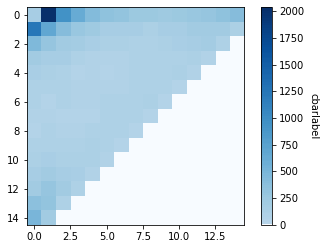

In [125]:
fig, ax = plt.subplots()
bottom = plt.cm.get_cmap('Blues', 128)
newcolors = np.vstack((bottom(0),
                       bottom(np.linspace(0.3, 1, 128))))
newcmp = matplotlib.colors.ListedColormap(newcolors, name='OrangeBlue')
im = ax.imshow(h_m, cmap=newcmp)
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("cbarlabel", rotation=-90, va="bottom")
plt.show()

In [43]:
score_history = np.load("data/linear_features/score_history/score_history.npy")
# score_history = score_history[score_history[:, 3].argsort()]
score_history = pd.DataFrame(score_history, columns=["k", "power", "normalization", "acc", "f1_score_macro"])
print(score_history)
# score_history.to_csv("data/linear_features/score_history/dle_point_score_history_1123.csv", index=False)

      0     1    2         3
0   1.0   4.0  0.0  0.552361
1   1.0   4.0  1.0  0.577002
2   1.0   4.0  2.0  0.535934
3   1.0   4.0  3.0  0.542094
4   1.0   6.0  0.0  0.546201
..  ...   ...  ...       ...
59  4.0   8.0  3.0  0.924025
60  4.0  10.0  0.0  0.683778
61  4.0  10.0  1.0  0.882957
62  4.0  10.0  2.0  0.850103
63  4.0  10.0  3.0  0.928131

[64 rows x 4 columns]


In [2]:
df = pd.read_csv("data/linear_features/cdhit80_data_seq_loc75_train.csv")

In [3]:
data_x = df["Sequence"]
data_y = np.where(df["loc"].to_numpy() == "Cytosolic", 1, 0)

In [4]:
x = np.load("data/linear_features/cdhit80_loc75_k1_power8_nor3.npy")
print(x.shape)

(2432, 37)


In [ ]:
x = None
for i in range(64):
    if x is None:
        x = np.array([data_x[:, i*10 + 4]]).T
        # x = np.array([data_x[:, i*10], data_x[:, i*10 + 9]]).T
        # x = np.array([np.average(data_x[:, i*10:(i+1)*10], axis=1)]).T
    else:
        x = np.append(x, np.array([data_x[:, i*10 + 4]]).T, axis=1)
        # x = np.append(x, np.array([data_x[:, i*10], data_x[:, i*10 + 9]]).T, axis=1)
        # x = np.append(x, np.array([np.average(data_x[:, i*10:(i+1)*10], axis=1)]).T, axis=1)
print(x.shape)

In [5]:
x_train, x_test, y_train, y_test = train_test_split(x, data_y, test_size=0.20, shuffle=True, random_state=12)

In [6]:
print(np.unique(data_y, return_counts=True))
print(np.unique(y_train, return_counts=True))

(array([0, 1]), array([ 187, 2245]))
(array([0, 1]), array([ 147, 1798]))


In [6]:
clf = svm.SVC(kernel='linear', class_weight='balanced')
scores = cross_val_score(clf, x, data_y, cv=5, scoring='f1_macro')

In [7]:
print("score:", scores)
y_pred = clf.predict(x_test)
print("macro:", f1_score(y_test, y_pred, average='macro'))

score: [0.85343261 0.80478554 0.85592885 0.83167797 0.72709271]


NotFittedError: This SVC instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [7]:
clf = svm.SVC(kernel='linear', C=1, class_weight='balanced').fit(x_train, y_train)
            
score = clf.score(x_test, y_test)
print("score:", score)
y_pred = clf.predict(x_test)
print("macro:", f1_score(y_test, y_pred, average='macro'))

score: 0.971252566735113
macro: 0.9175773694390716


In [8]:
print(np.unique(y_test, return_counts=True))
print(x_test[y_test == 1].shape)
print(x_test[y_test == 0].shape)
print(clf.score(x_test[y_test == 0], y_test[y_test == 0]))
print(clf.score(x_test[y_test == 1], y_test[y_test == 1]))
y_pred = clf.predict(x_test)
print("macro:", f1_score(y_test, y_pred, average='macro'))

(array([0, 1]), array([ 40, 447]))
(447, 37)
(40, 37)
1.0
0.9686800894854586
macro: 0.9175773694390716


In [10]:
import pickle
with open('data/k_mers/model/k1p8n3_svm.pickle', 'wb') as f:
    pickle.dump(clf, f)

In [11]:
with open('data/k_mers/model/k1p8n3_svm.pickle', 'rb') as f:
    clf2 = pickle.load(f)
y_pred = clf2.predict(x_test)
print("macro:", f1_score(y_test, y_pred, average='macro'))

macro: 0.9175773694390716


In [39]:
import time
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import datasets
from sklearn import svm
from sklearn.metrics import f1_score
from sklearn import metrics

from libsvm.svmutil import *
from imblearn.over_sampling import SMOTE

k_array = [1]
nor_array = [2]
num_array = [1]
k_array = [1, 2, 3, 4]
nor_array = [2, 3]
num_array = [1, 2, 3, 5, 8, 10]

data_y = np.load("data/linear_features/data_y.npy")

score_history = None
start_time = time.time()
for k in k_array:
    for nor in nor_array:
        for num in num_array:
            print("k=%s, nor=%s, num=%s" % (k, nor, num))
            
            data_x = np.load("data/linear_features/point/k" + str(k) + "nor" + str(nor) + "n" + str(num) + ".npy")
            data_x = data_x.reshape(data_x.shape[0],-1)
            print(data_x.shape)
            
            x_train, x_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.20, shuffle=True, random_state=12)
            
            prob = svm_problem(y_train, x_train, isKernel=True)
            param = svm_parameter('-t 0 -w0 1798 -w1 147')
            m = svm_train(prob, param)
            p_label, p_acc, p_val = svm_predict(y_test, x_test, m)
            (score, MSE, SCC) = evaluations(y_test, p_label)
            macro = f1_score(y_test, p_label, average='macro')
            print("score:", score)
            print("macro:", macro)
            print(metrics.confusion_matrix(y_test, p_label) / len(y_test))
            # if macro >= 0.6:
            #     with open("data/linear_features/model/k" + str(k) + "nor" + str(nor) + "n" + str(num) + "point_1122_" + str(start_time) + ".pickle", 'wb') as f:
            #         pickle.dump(clf, f)
            
            if score_history is None:
                score_history = np.array([[k, nor, num, data_x.shape[1], score, macro]])
            else:
                score_history = np.append(score_history, [[k, nor, num, data_x.shape[1], score, macro]], axis=0)
print(score_history)

k=1, nor=2, num=1
(2432, 4)
Accuracy = 41.0678% (200/487) (classification)
score: 41.067761806981515
macro: 0.3470721509821783
[[0.04928131 0.03285421]
 [0.55646817 0.3613963 ]]
k=1, nor=2, num=2
(2432, 8)
Accuracy = 66.7351% (325/487) (classification)
score: 66.73511293634496
macro: 0.44798488664987407
[[0.01848049 0.06365503]
 [0.26899384 0.64887064]]
k=1, nor=2, num=3
(2432, 12)
Accuracy = 29.7741% (145/487) (classification)
score: 29.774127310061605
macro: 0.2699610772143909
[[0.0513347  0.03080082]
 [0.67145791 0.24640657]]
k=1, nor=2, num=5
(2432, 20)
Accuracy = 19.3018% (94/487) (classification)
score: 19.301848049281315
macro: 0.1907117758242316
[[0.0698152  0.01232033]
 [0.79466119 0.12320329]]
k=1, nor=2, num=8
(2432, 32)
Accuracy = 13.1417% (64/487) (classification)
score: 13.141683778234087
macro: 0.13105045366538856
[[0.07597536 0.00616016]
 [0.862423   0.05544148]]
k=1, nor=2, num=10
(2432, 40)
Accuracy = 9.65092% (47/487) (classification)
score: 9.650924024640657
macro: 

In [38]:
from libsvm.svmutil import *
from imblearn.over_sampling import SMOTE

print(np.unique(y_train, return_counts=True))

# sm = SMOTE(random_state=42)
# x_res, y_res = sm.fit_resample(x_train, y_train)
# prob = svm_problem(y_res, x_res, isKernel=True)
prob = svm_problem(y_train, x_train, isKernel=True)
param = svm_parameter('-t 0 -w0 1798 -w1 147')
m = svm_train(prob, param)
p_label, p_acc, p_val = svm_predict(y_test, x_test, m)
print(f1_score(y_test, p_label, average='macro'))

(array([0, 1]), array([ 147, 1798]))
Accuracy = 41.0678% (200/487) (classification)
0.3470721509821783


In [11]:
from libsvm.svmutil import *
from imblearn.over_sampling import SMOTE

prob = svm_problem(data_y, x, isKernel=True)
param = svm_parameter('-v 10')
svm_train(prob, param)

Cross Validation Accuracy = 92.3109%


92.3108552631579

In [43]:
f_array = np.load("data/linear_features/k2_power10.npy")
vocab = np.load("data/linear_features/k2_vocab.npy")
print(f_array.shape)

(2432, 16, 11)


In [44]:
token_out = 10
data = []
for f in f_array:
    f_p = np.array([])
    for z in f:
        p = np.poly1d(z)
        f_p = np.append(f_p, p(np.linspace(0, 1.0, num=token_out)))
    data.append(f_p)
x = np.array(data)
print(x.shape)

(2432, 160)


In [52]:
k = 1
nor_str = "_norL"
data_df = pd.read_csv("data/linear_features/old/cdhit80_k" + str(k) + "_linear10" + nor_str + "_loc75.csv")
vocab = np.load("data/linear_features/old/cdhit80_k" + str(k) + "_vocab.npy")

In [31]:
col = data_df.columns
data_x = data_df[col[:-2]].to_numpy()
data_y = data_df[col[-1]].to_numpy()
data_y = np.where(data_y == "Cytosolic", 1, 0)

idx = np.arange(len(data_y))
np.random.shuffle(idx)
x_train = data_x[idx[:int(len(idx) * 0.8)]]
y_train = data_y[idx[:int(len(idx) * 0.8)]]
x_test = data_x[idx[int(len(idx) * 0.8):]]
y_test = data_y[idx[int(len(idx) * 0.8):]]
print(x_train.shape)
y_weight = np.unique(y_train, return_counts=True)[1]
print(y_weight)
print(x_test.shape)
print(np.unique(y_test, return_counts=True))

(1945, 176)
[ 142 1803]
(487, 176)
(array([0, 1]), array([ 38, 449]))


In [4]:
prob = svm_problem(y_train, x_train, isKernel=True)
param = svm_parameter('-t 1 -c 4 -w0 ' + str(y_weight[1]) + ' -w1 ' + str(y_weight[0]))
m = svm_train(prob, param)
p_label, p_acc, p_val = svm_predict(y_test, x_test, m)

NameError: name 'svm_problem' is not defined

In [32]:
preformance_vacab = []

for i in range(len(vocab)):
    x_v_train = x_train[:, 11*i:11*i+11]
    x_v_test = x_test[:, 11*i:11*i+11]
    # x_v_train = np.append(x_train[:, 11*i:11*i+11], np.array([x_train[:, -1]]).T, axis=1)
    # x_v_test = np.append(x_test[:, 11*i:11*i+11], np.array([x_test[:, -1]]).T, axis=1)
    # prob = svm_problem(y_train, x_train[:, 11*i:11*i+11], isKernel=True)
    # param = svm_parameter('-t 1 -c 10 -w0 ' + str(y_weight[1]) + ' -w1 ' + str(y_weight[0]))
    # m = svm_train(prob, param)
    # p_label, p_acc, p_val = svm_predict(y_test, x_test[:, 11*i:11*i+11], m)
    # f1 = f1_score(y_test, p_label, average=None)
    # print(f1)
    clf = svm.SVC(kernel='rbf', C=1, class_weight='balanced').fit(x_v_train, y_train)
    y_pred = clf.predict(x_v_test)
    f1_macro = f1_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average=None)
    preformance_vacab.append([i, f1_macro, f1[0], f1[1]])
    # print("score:", clf.score(x_test[:, 11*i:11*i+11], y_test))
preformance_vacab = np.array(preformance_vacab)
preformance_vacab = preformance_vacab[np.argsort(preformance_vacab[:, 1])]

In [33]:
preformance_vacab[-5:]

array([[12.        ,  0.44893685,  0.17283951,  0.7250342 ],
       [11.        ,  0.44952274,  0.16806723,  0.73097826],
       [13.        ,  0.45393055,  0.15454545,  0.75331565],
       [ 1.        ,  0.48629033,  0.1761658 ,  0.79641485],
       [ 7.        ,  0.50354369,  0.16      ,  0.84708738]])

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.20, shuffle=True, random_state=12)

In [22]:
value_counts = train_df["loc"].value_counts()

for i in range(len(value_counts)):
    while (max(value_counts) - value_counts[i]) / max(value_counts) > .1:
        print((max(value_counts) - value_counts[i]) / max(value_counts))
        train_df = train_df.append(train_df[train_df["loc"] == value_counts.index[i]][:(max(value_counts) - value_counts[i])])
        value_counts = train_df["loc"].value_counts()

print(value_counts)


0.9194444444444444
0.8388888888888889
0.6777777777777778
0.35555555555555557
Cytosolic    1800
Nucleus      1800
Name: loc, dtype: int64


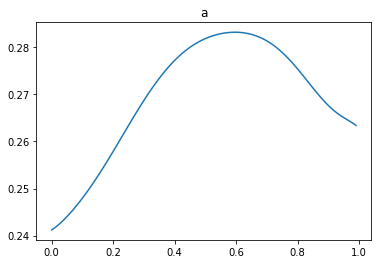

In [55]:
col = data_df.columns
cyt_df = data_df[data_df["loc"] == "Cytosolic"]
cyt_l = cyt_df.loc[:, ["len"]].to_numpy()
cyt_l = np.ones_like(cyt_l)

len_v = int((len(col)-2) / 11)

for i in range(len_v):
    for z, l in zip(cyt_df.loc[:, col[11*i:11*i+11]].to_numpy(), cyt_l):
        t = np.arange(0, l, 0.01)
        p = np.poly1d(z)

        plt.plot(t, p(t), alpha=1, color="#1f77b4")
        break
        
    # plt.xlim(0, np.average(cyt_l))
    plt.title(vocab[i])
    plt.show()
    break


[0.30459667 0.30563531 0.30480713 0.30405863 0.30499612 0.30685001
 0.30871487 0.3108631  0.31331082 0.31590429]


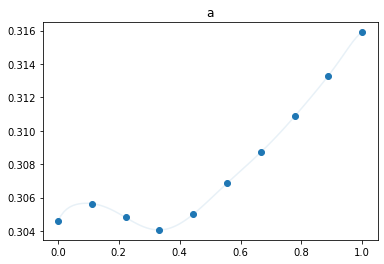

In [59]:
nuc_df = data_df[data_df["loc"] == "Nucleus"]
nuc_l = nuc_df.loc[:, ["len"]].to_numpy()
nuc_l = np.ones_like(nuc_l)
len_v = int((len(col)-2) / 11)

for i in range(len_v):
    for z, l in zip(nuc_df.loc[:, col[11*i:11*i+11]].to_numpy(), nuc_l):
        t = np.arange(0, l, 0.01)
        p = np.poly1d(z)

        plt.plot(t, p(t), alpha=0.1, color="#1f77b4")
        t = np.linspace(0, 1.0, num=10)
        plt.scatter(t, p(t))
        print(p(t))
        break
    # plt.xlim(0, 1)
    plt.title(vocab[i])
    plt.show()
    break

In [106]:
class NN2Layers(torch.nn.Module):
    def __init__(self, ninp: int, nhid: int, ntoken: int, dropout: float=0.0):
        
        super(NN2Layers, self).__init__()
        self.drop = nn.Dropout(dropout)
        self.nn1 = nn.Linear(ninp, nhid)
        self.nn2 = nn.Linear(nhid, ntoken)

        self.init_weights()

        self.ninp = ninp
        self.nhid = nhid
        self.ntoken = ntoken

    def init_weights(self):
        initrange = 0.1
        self.nn1.bias.data.zero_()
        self.nn1.weight.data.uniform_(-initrange, initrange)
        self.nn2.bias.data.zero_()
        self.nn2.weight.data.uniform_(-initrange, initrange)

    def forward(self, x: torch.tensor):

        output = self.nn1(x)
        output = self.drop(output)
        output = self.nn2(output)

        return output.softmax(dim=1)
 
    def predict(self, x: torch.tensor):
        # """預測並輸出機率大的類別

        # Args:
        #     x (torch.tensor): 詞 tensor。如果batch_first=True，input shape為（批次，序列），否則（序列，批次）。

        # Returns:
        #     [torch.tensor]: shape 與 x 一樣，但是序列為類別序列。
        # """
        output = self.forward(x)
        _, output = torch.max(output, 1)

        return output

In [151]:
x = x_train
y = y_train
# y = np.where(y == "Cytosolic" , 1, 0)

unique, counts = np.unique(y, return_counts=True)

y_weight = np.unique(y, return_counts=True)[1] / len(y)
y_weight = np.abs(y_weight - 1)
print(y_weight)

[0.92699229 0.07300771]


In [210]:
ntoken = 2

ninp = x_train.shape[1]
nhid = 512

model = NN2Layers(ninp, nhid, ntoken)
loss_fn = nn.CrossEntropyLoss(weight=torch.tensor(y_weight).to(torch.float))
# optimizer = optim.AdamW(model.parameters(), lr=3e-3, weight_decay=1e-4)
optimizer = optim.SGD(model.parameters(), lr=3e-1)

batch_size = 8
epochs = 500

tensor_x = torch.tensor(x_train).to(torch.float)
tensor_y = torch.tensor(y_train).to(torch.long)

test_x = torch.tensor(x_test).to(torch.float)
test_y = torch.tensor(y_test).to(torch.long)

# dataset = Data.TensorDataset(tensor_x, tensor_y)

# # train_set, valid_set = Data.random_split(dataset, [int(len(dataset) * 0.8), len(dataset) - int(len(dataset) * 0.8)], generator=torch.Generator().manual_seed(42))

# loader = Data.DataLoader(
#     dataset = dataset,
#     batch_size = batch_size,
# )

In [195]:
class Trainer():
    def __init__(self, model, optimizer, loss_fn):
        self.model = model
        self.optimizer = optimizer
        self.loss_fn = loss_fn
    
    def train(self, x, y, epochs = 2, batch_size = 1, epoch_print = True):
        train_dataset = Data.TensorDataset(x, y)
        loader = Data.DataLoader(
            dataset = train_dataset,
            batch_size = batch_size,
        )
        
        start_time = time.time()
        step_size = len(loader)
        for epoch in range(epochs):
            for step, (batch_x, batch_y) in enumerate(loader):
                step_time = time.time()
                
                self.optimizer.zero_grad()
                pred_y = self.model(batch_x)
                loss = self.loss_fn(pred_y, batch_y)
                loss.backward()
                self.optimizer.step()
                
                # print('Epoch: %i | Step: %i/%i | Loss: %.2f | time: %.2f s' % (epoch, step, step_size, loss, time.time() - step_time))
            if epoch_print:
                print('Epoch: %i | Loss: %.2f | time: %.2f s' % (epoch, loss, time.time() - step_time))
        print('All Time: %.2f s | Loss: %.2f' % (time.time() - start_time, loss))
    
    def test(self, x, y):
        y_pred = self.model.predict(x)
        
        one_hot_y = np.eye(self.model.ntoken)[y]
        one_hot_y_pred = np.eye(self.model.ntoken)[y_pred]
        token_acc_array = []
        for i in range(self.model.ntoken):
            y_token = torch.tensor(one_hot_y[:, i])
            y_pred_token = torch.tensor(one_hot_y_pred[:, i])
            
            tp = (y_token * y_pred_token).sum(dim=0).to(torch.float32)
            tn = ((1 - y_token) * (1 - y_pred_token)).sum(dim=0).to(torch.float32)
            fp = ((1 - y_token) * y_pred_token).sum(dim=0).to(torch.float32)
            fn = (y_token * (1 - y_pred_token)).sum(dim=0).to(torch.float32)
            precision = tp / (tp + fp)
            rec = tp / (tp + fn)
            f1 = 2 * rec * precision / (rec + precision)
            token_acc_array.append(f1)
        acc = (y_pred == y).float().sum() / len(y)
        token_acc_array = torch.tensor(token_acc_array)
        return acc, token_acc_array

In [ ]:
trainer = Trainer(model, optimizer, loss_fn)
trainer.train(tensor_x, tensor_y, epochs, batch_size, epoch_print=False)
trainer.test(test_x, test_y)

In [211]:
preformance_vacab = []
for i in range(len(vocab)):
    model = NN2Layers(11, nhid, ntoken)
    trainer = Trainer(model, optimizer, loss_fn)
    trainer.train(tensor_x[:, 11*i:11*i+11], tensor_y, epochs, batch_size, epoch_print=False)
    acc, token_acc_array = trainer.test(test_x[:10, 11*i:11*i+11], test_y[:10])
    
    preformance_vacab.append(np.append(np.array([i, acc, torch.min(token_acc_array)]), token_acc_array))
preformance_vacab = np.array(preformance_vacab)
preformance_vacab = preformance_vacab[np.argsort(preformance_vacab[:, 2])]

All Time: 43.67 s | Loss: 0.69
All Time: 42.74 s | Loss: 0.69
All Time: 43.57 s | Loss: 0.69
All Time: 44.38 s | Loss: 0.69
All Time: 44.36 s | Loss: 0.69
All Time: 43.77 s | Loss: 0.69
All Time: 43.93 s | Loss: 0.69
All Time: 43.48 s | Loss: 0.69
All Time: 43.79 s | Loss: 0.69
All Time: 44.10 s | Loss: 0.69
All Time: 43.94 s | Loss: 0.70
All Time: 43.93 s | Loss: 0.69
All Time: 43.86 s | Loss: 0.69
All Time: 44.28 s | Loss: 0.69
All Time: 44.88 s | Loss: 0.69
All Time: 45.26 s | Loss: 0.69


In [212]:
preformance_vacab

array([[ 0.        ,  0.1       ,         nan,  0.18181819,         nan],
       [ 1.        ,  0.89999998,         nan,         nan,  0.94736838],
       [ 2.        ,  0.1       ,         nan,  0.18181819,         nan],
       [ 3.        ,  0.1       ,         nan,  0.18181819,         nan],
       [ 4.        ,  0.89999998,         nan,         nan,  0.94736838],
       [ 5.        ,  0.89999998,         nan,         nan,  0.94736838],
       [ 6.        ,  0.89999998,         nan,         nan,  0.94736838],
       [ 7.        ,  0.89999998,         nan,         nan,  0.94736838],
       [ 8.        ,  0.89999998,         nan,         nan,  0.94736838],
       [ 9.        ,  0.89999998,         nan,         nan,  0.94736838],
       [10.        ,  0.1       ,         nan,  0.18181819,         nan],
       [11.        ,  0.89999998,         nan,         nan,  0.94736838],
       [12.        ,  0.1       ,         nan,  0.18181819,         nan],
       [13.        ,  0.89999998,     

In [52]:
start_time = time.time()
step_size = len(loader)
for epoch in range(epochs):
    correct = 0
    for step, (batch_x, batch_y) in enumerate(loader):
        step_time = time.time()
        model.zero_grad()
        pred = model(batch_x)
        loss = loss_fn(pred, batch_y)
        # print('Epoch: %i | Step: %i/%i | Loss: %.2f | time: %.2f s' % (epoch, step, step_size, loss, time.time() - step_time))
        loss.backward()
        optimizer.step()
        
        correct += (torch.argmax(pred, dim=1) == batch_y).float().sum()

    accuracy = 100 * correct / len(loader.dataset)
    print('Epoch: %i | Loss: %.2f | Accuracy: %.2f | time: %.2f s' % (epoch, loss, accuracy, time.time() - step_time))

print('all time : ', time.time() - start_time,'s')

Epoch: 0 | Loss: 0.67 | Accuracy: 91.57 | time: 0.01 s
Epoch: 1 | Loss: 0.65 | Accuracy: 92.19 | time: 0.00 s
Epoch: 2 | Loss: 0.62 | Accuracy: 92.19 | time: 0.00 s
Epoch: 3 | Loss: 0.59 | Accuracy: 92.19 | time: 0.00 s
Epoch: 4 | Loss: 0.56 | Accuracy: 92.19 | time: 0.00 s
Epoch: 5 | Loss: 0.52 | Accuracy: 92.19 | time: 0.00 s
Epoch: 6 | Loss: 0.49 | Accuracy: 92.19 | time: 0.00 s
Epoch: 7 | Loss: 0.46 | Accuracy: 92.19 | time: 0.00 s
Epoch: 8 | Loss: 0.44 | Accuracy: 92.19 | time: 0.00 s
Epoch: 9 | Loss: 0.42 | Accuracy: 92.19 | time: 0.00 s
Epoch: 10 | Loss: 0.40 | Accuracy: 92.19 | time: 0.00 s
Epoch: 11 | Loss: 0.39 | Accuracy: 92.19 | time: 0.00 s
Epoch: 12 | Loss: 0.38 | Accuracy: 92.19 | time: 0.00 s
Epoch: 13 | Loss: 0.37 | Accuracy: 92.19 | time: 0.00 s
Epoch: 14 | Loss: 0.36 | Accuracy: 92.19 | time: 0.00 s
Epoch: 15 | Loss: 0.35 | Accuracy: 92.19 | time: 0.00 s
Epoch: 16 | Loss: 0.35 | Accuracy: 92.19 | time: 0.00 s
Epoch: 17 | Loss: 0.34 | Accuracy: 92.19 | time: 0.00 s
Ep

KeyboardInterrupt: 

In [138]:
def valid(vaild_data):
    model.eval()
    with torch.no_grad():
        for step, (batch_x, batch_y) in enumerate(loader):
            pred = model(batch_x)
            print(pred.softmax(dim=1))
            print(pred)
            print(batch_y)
            break

valid_loader = Data.DataLoader(
    dataset = valid_set,
    batch_size = 5,
)
valid(valid_loader)

tensor([[0.7311, 0.2689],
        [0.7310, 0.2690],
        [0.7311, 0.2689],
        [0.7311, 0.2689],
        [0.7310, 0.2690],
        [0.7305, 0.2695],
        [0.7311, 0.2689],
        [0.7311, 0.2689],
        [0.7298, 0.2702],
        [0.7311, 0.2689]])
tensor([[1.0000e+00, 2.6870e-09],
        [9.9980e-01, 2.0265e-04],
        [1.0000e+00, 1.9828e-07],
        [1.0000e+00, 2.3776e-15],
        [9.9996e-01, 4.4885e-05],
        [9.9870e-01, 1.3012e-03],
        [1.0000e+00, 1.5889e-10],
        [9.9999e-01, 1.0258e-05],
        [9.9675e-01, 3.2475e-03],
        [1.0000e+00, 8.9727e-10]])
tensor([1, 1, 0, 1, 1, 1, 1, 1, 1, 1])
